In [1]:
import numpy as np
from scipy import signal
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from natsort import natsorted
import pandas as pd
from scipy.signal import butter, lfilter, freqz, filtfilt
from scipy.special import erfc

import matplotlib.pyplot as plt
plt.style.use('../../style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from datetime import datetime
from datetime import timedelta
import re, os
import h5py
import pandas as pd

In [2]:
import sys
sys.path.insert(0,'../../')
sys.path.insert(0,'../../WaveformAnalysis')

In [3]:
import Dataset as Dataset
import StandMonitor as Monitor
import PlotFunctions as Plt
from Waveform import Waveform
from SiPM import SiPM

In [4]:
#load data from files using the SiPM class
data=SiPM(Path='C:/Data/20220525/',Selection='*V*.h5')

#load the Channel attribute
data.Ch=[Waveform(ID=1,Pol=-1)]
print (len(data.Files))

9


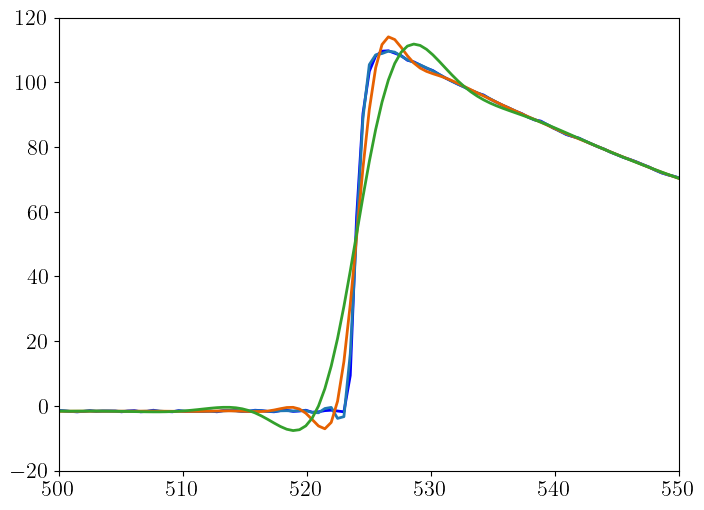

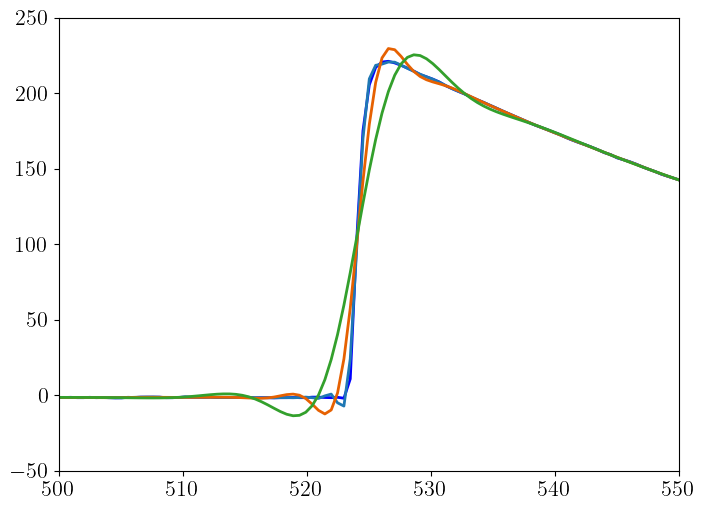

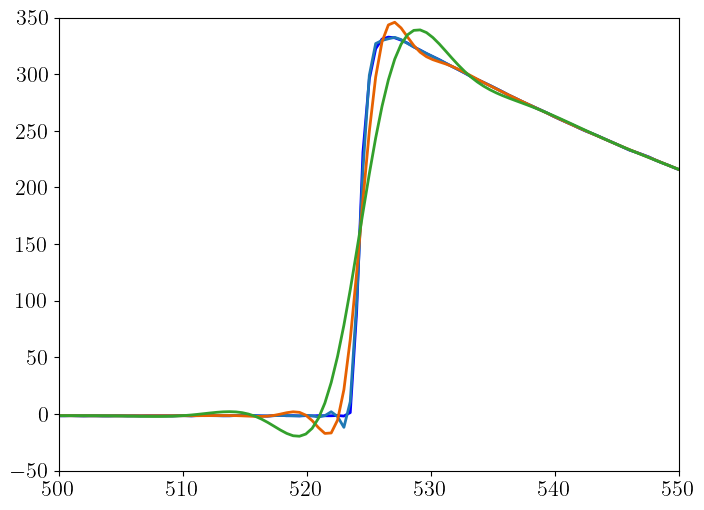

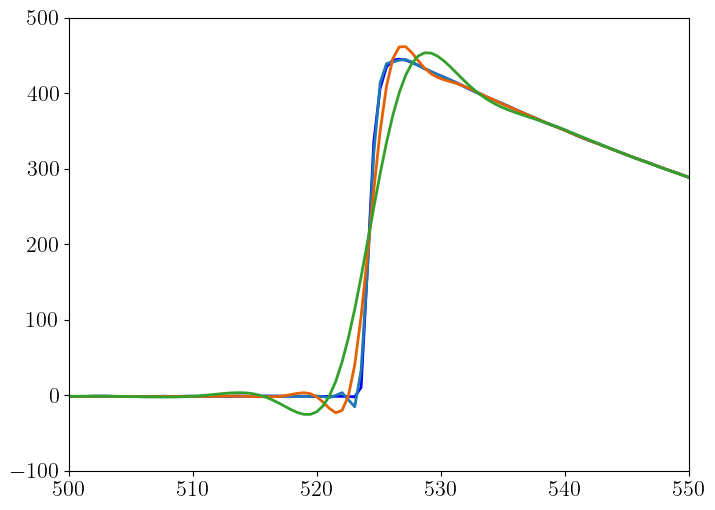

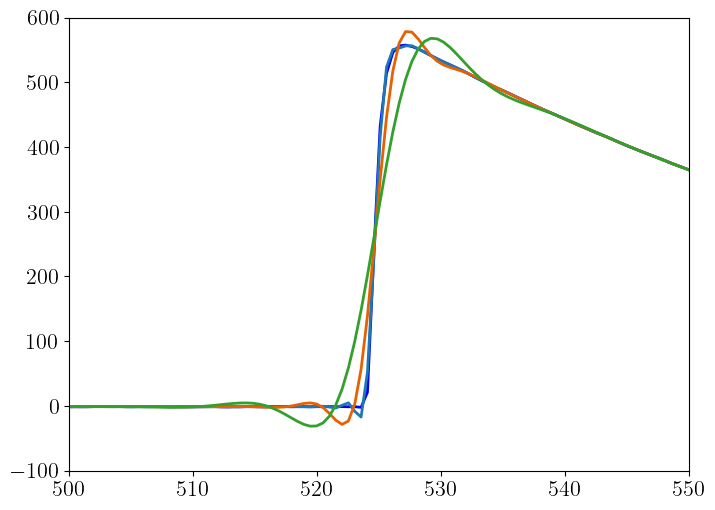

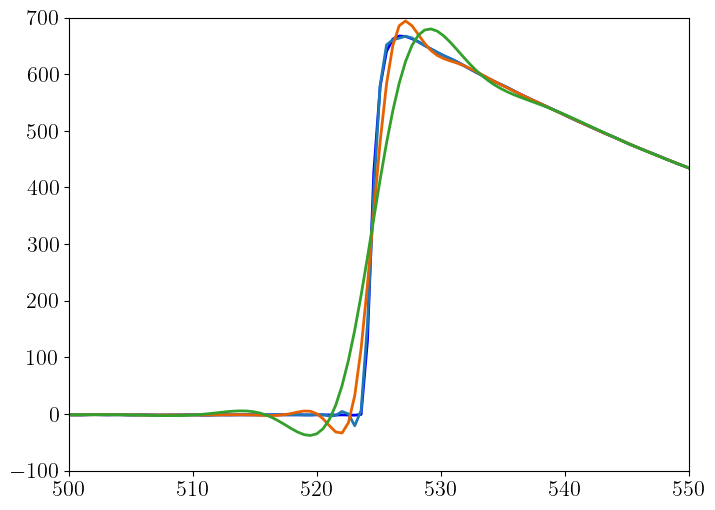

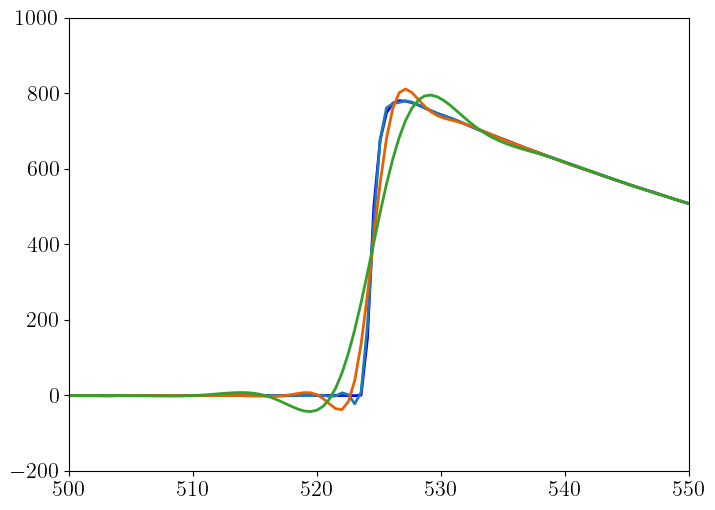

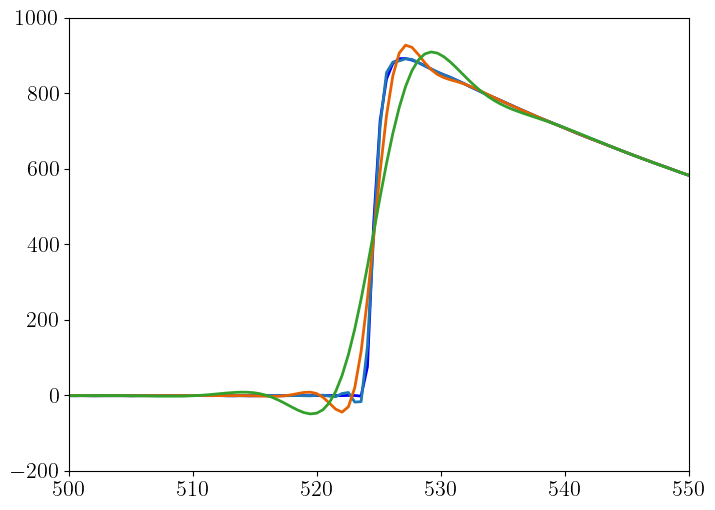

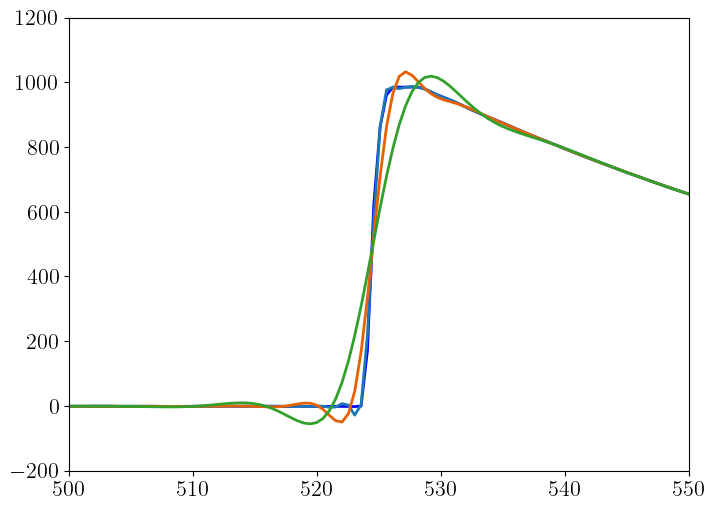

In [10]:
#loop over files and load data using the ImportDataFromHDF5 function in Dataset class

data.Files=natsorted(data.Files)

for File in data.Files:
    loaded_data=SiPM(Path=File) # Call the SiPM Class
    loaded_data.Ch=[Waveform(ID=2,Pol=-1)] # Since we only have data from a single channel, we store it in an array
    loaded_data.ImportDataFromHDF5(File,loaded_data.Ch,var=[]) #Import data from the HD5 file with empty var array since we don't need trigger or time stamp


    # for amps in loaded_data.Ch[0].Amp:
    #     plt.plot(loaded_data.Ch[0].Time,amps)
    #     plt.show()
    # nsamps=len(loaded_data.Ch[0].Amp[0])
    # print(nsamps)
    # resp_x=np.linspace(0,20,nsamps)
    # template=func(resp_x,0,1,0.183,49.5,3.02)
    # norm=np.sum(template**2)
    
    loaded_data.get_sampling()
    loaded_data.sampling_freq
    
    loaded_data.shaping_time=[2e-6,5e-6,10e-6]
    loaded_data.setup_butter_filter() # calculate the butterworth filter coefficients 
    
    for waveform in loaded_data.Ch[0].Amp: #loop over the waveforms inside the file
        y=loaded_data.get_filtered_waveform(waveform) # return the filtered waveform
        plt.plot(loaded_data.Ch[0].Time,waveform,color='b')
        [plt.plot(loaded_data.Ch[0].Time,y1) for y1 in y]
        plt.xlim(500,550)
        plt.show()

    

In [ ]:
def make_filter(data_time, highfreq=1e5, lowfreq=100):

    fs=1/(np.mean(np.diff(data_time))/1E6)
    nyq=0.5*fs

    order=3
    lowfreq=lowfreq
    highfreq=highfreq
    # type='band'

    b, a = butter(order, [lowfreq/nyq, highfreq/nyq], btype='band', analog=False)

    return b,a

In [13]:
def make_band_filter(data_time, highfreq=1e5, lowfreq=1000):

    fs=1/(np.mean(np.diff(data_time))/1E6)
    nyq=0.5*fs

    order=1
    lowfreq=lowfreq
    highfreq=highfreq
    # type='band'

    b, a = butter(order, highfreq/nyq, btype='low', analog=False)
    b2, a2 = butter(order, lowfreq/nyq, btype='high', analog=False)

    return b,a,b2,a2


In [14]:
def apply_filter(wf, b, a):
    filtamp = filtfilt(b,a,wf)
    return filtamp

In [15]:
def func(x,base,V0,sigma,tau,mu):
    return base + V0/2.0 * np.exp(0.5 * (sigma/tau)**2 - (x-mu)/tau) * erfc(1.0/np.sqrt(2.0) * (sigma/tau - (x-mu)/sigma))
    
def gauss_conv(x, mu=0, sigma=0.1):
    x = x-mu
    return np.exp(-np.square((x-mu)/sigma)/2)/(sigma*np.sqrt(2*np.pi))

def apply_opt_filt(data_time, filtered_amp):
    desire_x = np.arange(-500,500, data_time[1]-data_time[0])
    desire_y = gauss_conv(desire_x)
    desire_f = np.fft.fft(desire_y)

    resp_x = np.arange(0,1000, data_time[1]-data_time[0])
    resp_y = func(resp_x, 0, 1, 1.83, 46.93, 0)
    resp_f = np.fft.fft(resp_y)

    filter_f = desire_f/resp_f
    filter_y = np.real(np.fft.ifft(filter_f))
    
    convol=np.convolve(filtered_amp, filter_y,'same')
    #print('convol length', len(filtered_amp), len(filter_y), len(convol))
        
    return convol
    

In [16]:
def search_waveform_for_peaks(vals, data_time, h=0.01, d=50):
    peak_height = []
    peak_pos = []
    
    peaks,pdict = find_peaks(vals,height=h)
    
    ## sometimes there seems to be a problem with the time vector from teh dataset
    ## so kludgily fix to make sure it always works
    kludged_time_vec = np.linspace(data_time[0],data_time[-1],len(vals))
    
    #print(peaks)
    
    for peak, height in zip(peaks, pdict['peak_heights']):
        
        ## skip early peaks due to edge effect
        if(peak <= d): 
            continue
        
        peak_height.append(height)
        peak_pos.append(kludged_time_vec[peak])

    return peak_height, peak_pos

In [17]:
def apply_time_refit(data,n=10000):
    
    ## first fit the pulse at the trigger time (all in us)
    fs=1/(20/n) ## hard coding 20 ms window with 1e4 samples since this is wrong in the data files
    resp_x = np.linspace(0, 20, n)
    #resp_y = func(resp_x, 0, 1, 0.15, 49, 3.05)
    
    ## only allow positive going pulses
    cfun = lambda x,A: func(x, 0, np.abs(A), 0.183, 49.5, 3.02)
    cfun2 = lambda x,A,A2,t2: cfun(x, np.abs(A)) + func(x, 0, np.abs(A2), 0.183, 49.5, 3.02+np.abs(t2))
    
    bp, bc = curve_fit(cfun2, resp_x, data, p0=[30,30,0.5])
    
    if(False):
        plt.figure()
        plt.plot(resp_x, data)
        plt.plot(resp_x, cfun(resp_x, *bp))
        plt.show()
        input()
        
    return bp, cfun2(resp_x, *bp)

In [18]:
dir='C:/Data/20220506/'

amp=np.arange(0.5,10,0.5)
amp_max=[]
peak_data = []
plt.figure(figsize=(8,6))

for filename in os.listdir(dir):
    file= os.path.join(dir, filename)
    # print(file)
    f = h5py.File(file,'r')
    Keys=list(f.keys())
    # print(Keys)
    channel=np.array(f.get('Ch2'))*(-1)
    Time=np.array(f.get('Time')).flatten()
    # plt.plot(Time,channel,lw=2)
    b,a = make_filter(Time)
    filt_data = apply_filter(channel, b, a)
    # plt.plot(Time,filt_data,lw=2)
    opt_data = apply_opt_filt(Time, filt_data)
    plt.plot(Time,opt_data,lw=2)
    peak_height, peak_pos = search_waveform_for_peaks(opt_data, Time)
    # print(peak_pos)
    plt.plot(peak_pos,peak_height,'*')
    nsamps = len(channel)
    resp_x = np.linspace(0, 20, nsamps)
    template = func(resp_x, 0, 1, 0.183, 49.5, 3.02)
    norm = np.sum(template ** 2)
    template /= norm ## norm unity template from expected signal shape

    bs=np.mean(channel[:800])
    currwf=channel-bs
    temp_val = np.sum( currwf * template ) ## automatic template fit
               
    chi2 = np.sum( (currwf - temp_val*template*norm)**2 )
    chi2thresh = 1e5
    if(chi2 > chi2thresh):
        try:
            bp, rfittemp = apply_time_refit(currwf, n=nsamps)
        except RuntimeError:
            bp = 0
            rfit = np.zeros_like(currwf)
        chi2refit = np.sum( (currwf - rfittemp)**2 )


    xx = np.linspace(0,20e-6,nsamps)
    trig_time = 2.85e-6
    filtered_amps = []
    # for fdidx in range(len(fts_list)):
    #     time_val_to_use = np.argmin( np.abs(trig_time + fts_list[fdidx] - xx) )
    #     filtered_amps.append([ filt_data[fdidx][time_val_to_use], time_val_to_use ])


    
    f.close()
    amp_max.append(np.max(channel))

plt.xlabel('Time (ns)')
plt.ylabel('Amplitude (mV)')
plt.xlim(500,550)
plt.ylim(-0.02,0.15)
plt.show()


TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

<Figure size 800x600 with 0 Axes>

In [ ]:
def line(x,m,c):
    return m*x+c
popt,pcov=curve_fit(line,amp,amp_min,p0=[-0.05,0])

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(amp,amp_min)
plt.plot(amp,line(amp,*popt),lw=3,label='y = {:.3g} x + {:.3g}'.format(popt[0],popt[1]),color='r')
plt.xlabel('Func Gen Amplitude(V)')
plt.ylabel('RP Amplitude Minimum (mV)')
plt.legend(loc='best')
plt.show()

In [ ]:
dir='C:/Data/20220506/'

